In [1]:
import os, sys
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import starmap
%matplotlib inline

class Paths:
    #実験データもSelectPathに入れてしまうこと
    #外からPath.SelectPathを    
    def __init__(self,ExpType,DelType):
        self.SelectPath=self.select(glob.glob("./*/IF0*.DAT", recursive=True),Keys=ExpType,DelKeys=DelType)    #ExpType"が含まれているものがself.SelectPathに入る
        
    def select(self,path_list ,Keys=["__"],DelKeys=[]):
        check_name=lambda p_,keys_,delkeys_:all(x in p_ for x in keys_) and all(y not in p_ for y in delkeys_)  #keys_の全てがp_に含まれている場合:TRUE
        return [p for p in path_list if check_name(p,Keys,DelKeys)]
        
class DataSets:
    def __init__(self,ExpType,DelType):
        self.type=ExpType
        self.path=Paths(self.type,DelType).SelectPath #[path.lower() for path in Paths(self.type).SelectPath]
        self.name,self.sgm_eps,self.SH=[],[],[]
        
        self.name=[self.get_name(path) for path in self.path]
        self.sgm_eps=[self.preprocess(path) for path in self.path]
                    
    def preprocess(self,path):
        return self.preprocess_split(path) if "split" in self.type else self.preprocess_comp(path)
            
    def preprocess_comp(self,path):
        df=pd.read_table(path, sep="\s+", header=None)
        df_out=pd.DataFrame([])
        
        if "ExpData" not in path:
            LL,rad=self.get_size(path) #試験体長さ,半径
            #if df.iloc[:,-1].max()>0.1:
             #   idxload=df.iloc[:,-1].idxmax()
            if df.iloc[:,3].max()>0.1:    #時間の取り出し
                idxload=df.iloc[:,3].idxmax()
            else:
                idxload=0
            sh=df.iloc[idxload,0]/LL*10.0**6.0
            df_out["Strain"]=-(df.iloc[idxload:,0]-df.iloc[idxload,0])/LL*10.0**6.0 #ひずみ
            try:
                #df_out["Stress"]=-(df.iloc[idxload:,-2]-df.iloc[idxload,-2])/(rad**2.0*np.pi) #応力 
                df_out["Stress"]=-(df.iloc[idxload:,1]-df.iloc[idxload,1])/(rad**2.0*np.pi) #応力 
            except:
                df_out["Stress"]=-(df.iloc[idxload:,1]-df.iloc[idxload,1])/(rad**2.0*np.pi) #例外時
        else:
            df_out["Stress"]=df[1]
            df_out["Strain"]=df[0]
        
        self.SH.append(sh if "ExpData" not in path else np.nan)
        
        return df_out
        
    def preprocess_split(self,path):
        df_raw=pd.read_table(path, sep="\s+", header=None)
        
        idxload=df_raw.iloc[:,-1].idxmax() #乾燥収縮時のステップ()
        LL,rad=self.get_size(path) #試験体長さ,半径

        df=pd.DataFrame([])
        df["Strain"]=df_raw.iloc[idxload:,[i for i in range(df.shape[1]-1) if i%2==0]] .mean(axis=1) #実際はDispだけどStrainで
        df["Stress"]=-2.0*(df_raw.iloc[idxload:,-2]-df_raw.iloc[idxload,-2])/(np.pi*LL*2.0*rad)
        return df
        
    def get_size(self,path): #dictを使用するとか、もっと良いやり方があると思う
        if "fai5" in path:
            return 100.0, 25.0
        elif "fai10x5" in path:
            return 50.0, 50.0
        elif "fai10x2.5" in path:
            return 25.0, 50.0
        elif "fai10" in path:
            return 200.0, 50.0
        elif "fai4" in path:
            return 60.0, 20.0
    
    def get_name(self,path):
        if "ExpData" not in path:
            try:
                return re.findall("(?:fai.*)?(?:mortar.*)?(?:sealed|dried)(?:.*__)?", path)[0][:-2] #[:-2]->"__"の削除
            except:
                return path
        else:
            return re.findall("ExpData.*__",path)[0][:-2]+re.findall("IF0_.*DAT",path)[0][6:-4] #[0]:リストからstrを出す,[:-2],[6:-4]:stringから文字を選択
            
class Results:
    def __init__(self,types=["__"],deltypes=[]):
        #IF0があるディレクトリの相対パスを取得
        self.Ec, self.strength=[], []
        self.types=types
        self.sp_shape=[s for s in self.types if "fai" in s]
        self.data=DataSets(self.types,deltypes)
    
    def GetEcFc(self):
        get_strength=lambda x:0.0 if x.shape[0]<=1 else x["Stress"].max() #例外処理:収縮段階で解析がストップしている場合0.0を返す
        
        if "split" in self.types:
            for df, name in zip(self.data.sgm_eps, self.data.name): 
                self.strength.append(get_strength(df))
                print("{} : Ft={:.2f}".format(name, self.strength[-1]))
        else:
            for df, name, sh in zip(self.data.sgm_eps,self.data.name,self.data.SH): 
                self.strength.append(get_strength(df))
                self.Ec.append(self.get_Ec(df, self.strength[-1]))
            
                print("{} : Ec={:.2f}, Fc={:.2f}, SH={:.2f}".format(name, self.Ec[-1], self.strength[-1],sh))
        return self
    
    def get_Ec(self,df,fc):
        if df.shape[0]<=1: return np.nan #例外処理:収縮段階で解析がストップしている場合(dfには1行しか含まれていない)
        
        peak=df.loc[df["Stress"].idxmax()]["Strain"]
        if peak > 10000.0:
            print("Is Peak value too large? peak:{}".format(peak))
        df_elastic=df.query("80.0< Strain < @peak & 0.5 < Stress < 0.333*@fc+1.5") #1ステップで1MPa程度増加するので、切り捨て文を2.0で追加
        try:
            return np.polyfit(df_elastic["Strain"], df_elastic["Stress"], 1)[0]*1000.0 #Ecをreturn
        except:
            return np.nan
    
    def DrawStressStrain(self):
        for df, name in zip(self.data.sgm_eps,self.data.name):
            plt.plot(df["Strain"], df["Stress"], label=name)
        plt.xlabel("Strain(μ)")
        plt.ylabel("Stress(MPa)")
        plt.legend()
        plt.title("Compressive test")
        plt.savefig("Compressive_test.png",dpi=200)
        
    def DrawEcFc(self):
        if "split" in self.types:
            self.draw_bar(self.strength,self.data.name,"Tensile Strength")
        else:
            fig, (ax1, ax2) = plt.subplots(ncols=2) #, figsize=(10,4)
            
            ax1.bar(np.arange(len(self.Ec)), self.Ec, tick_label = self.data.name)
            ax1.set_xticklabels(self.data.name, rotation=90)
            
            ax2.bar(np.arange(len(self.strength)), self.strength, tick_label = self.data.name)
            ax2.set_xticklabels(self.data.name, rotation=90)            
            
            try:
                ax1.set_title("Young's Modulus: "+self.sp_shape[0])
                ax2.set_title("Compressive Strength: "+self.sp_shape[0])
            except:
                ax1.set_title("Young's Modulus")
                ax2.set_title("Compressive Strength")
            
    def draw_bar(self,list_data,label,title):
        plt.bar(np.arange(len(list_data)), list_data) #, tick_label = self.data.name
        plt.xticks(np.arange(len(list_data)), label, rotation="vertical")
        try:
            plt.title(title+": "+self.sp_shape[0])
        except:
             plt.title(title)
        
    def rm_shape(self,label):
        if not self.sp_shape: return label #shape指定がない場合触らない
        return [re.sub("fai.*?(_|-)","",name,1) for name in label]
        
    def Summary(self):
        self.GetEcFc()
        if "split" not in self.types: self.DrawStressStrain() 
        self.DrawEcFc()

fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=20 : Ec=23.20, Fc=25.02, SH=0.00
fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=35 : Ec=26.84, Fc=40.82, SH=0.00
fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=55 : Ec=30.92, Fc=59.55, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ec=19.41, Fc=21.60, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ec=23.05, Fc=37.68, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad : Ec=27.90, Fc=57.23, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Ogawa : Ec=19.38, Fc=22.92, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Yama : Ec=15.88, Fc=23.09, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Ogawa : Ec=23.02, Fc=39.99, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Yama : Ec=18.97, Fc=38.34, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Ogawa : Ec=27.85, Fc=60.80, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Yama : Ec=23.00, Fc=55.7

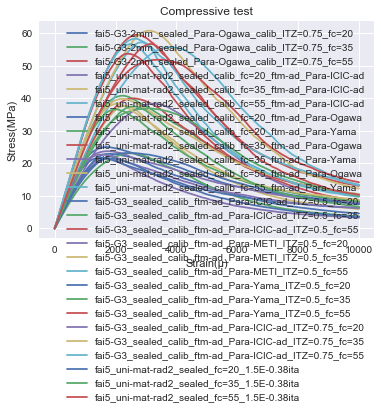

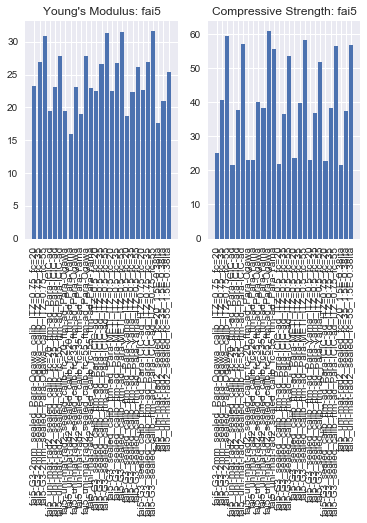

In [2]:
keys=["fai5","fc=","sealed","__"]
delkeys=["split"]
R=Results(keys,delkeys).Summary()

fai10x5-split-DIC-Take_sealed_Para-METI_ITZ=0.75_calib_fc=20 : Ft=2.29
fai10x5-split-DIC-Take_sealed_Para-METI_ITZ=0.75_calib_fc=35 : Ft=3.60
fai10x5-split-DIC-Take_sealed_Para-METI_ITZ=0.75_calib_fc=55 : Ft=5.01
fai10x5-split-DIC-Take_sealed_calib_Para-ICIC-ad_fc=55 : Ft=4.25
fai10x5-split-DIC-Take_sealed_calib_Para-Yama_fc=55 : Ft=3.41
fai10x5-split-DIC_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=1.68
fai10x5-split-DIC_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad_ITZ=0.75 : Ft=1.86
fai10x5-split-DIC_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=2.81
fai10x5-split-DIC_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad_ITZ=0.75 : Ft=3.17
fai10x5-split-DIC_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.96
fai10x5-split-DIC_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad_ITZ=0.75 : Ft=4.45
fai10x5-split-DIC_uni-mat-rad2.5_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ft=1.99
fai10x5-split-DIC_uni-mat-rad2.5_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ft=3.46
fai10x5-split-DIC_uni-mat-rad2.5_sealed_cal

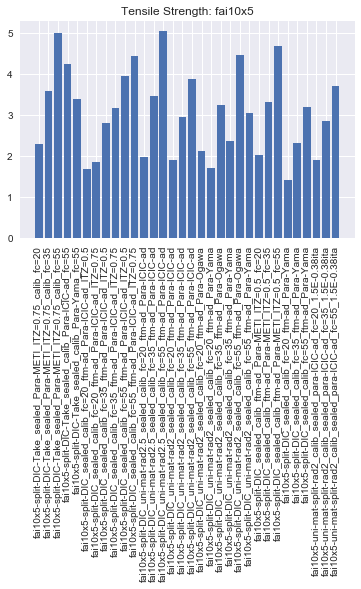

In [14]:
keys=["fai10x5","split","fc=","__"]
delkeys=[]
R_split=Results(keys,delkeys).Summary()

fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ec=19.41, Fc=21.60, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ec=23.05, Fc=37.68, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad : Ec=27.90, Fc=57.23, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Ogawa : Ec=19.38, Fc=22.92, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Yama : Ec=15.88, Fc=23.09, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Ogawa : Ec=23.02, Fc=39.99, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Yama : Ec=18.97, Fc=38.34, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Ogawa : Ec=27.85, Fc=60.80, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Yama : Ec=23.00, Fc=55.77, SH=0.00
fai5_uni-mat-rad2_sealed_para-ICIC-ad_fc=20_1.5E-0.38ita : Ec=17.63, Fc=21.57, SH=0.00
fai5_uni-mat-rad2_sealed_para-ICIC-ad_fc=35_1.5E-0.38ita : Ec=20.94, Fc=37.50, SH=0.00
fai5_uni-mat-rad2_sealed_para-ICIC-ad_fc=55_1.5E-0.38ita :

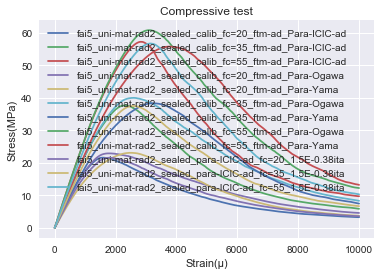

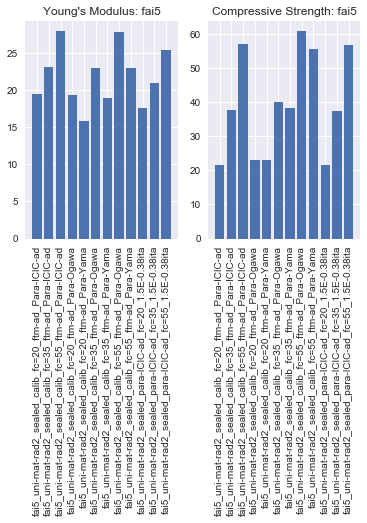

In [13]:
keys=["fai5","uni-mat","fc=","__"]
delkeys=["split"]
R_split=Results(keys,delkeys).Summary()

fai10x2.5-split-DIC-rad3_dried-60d_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.12
fai10x2.5-split-DIC-rad3_dried-RH20_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.12
fai10x2.5-split-DIC-rad3_dried-RH60_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=2.79
fai10x2.5-split-DIC-rad3_dried-RH80_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.38
fai10x2.5-split-DIC-rad3_sealed_ftm-ad_Para-ICIC-ad_ITZ=0.5_Em-ad : Ft=3.59
fai10x2.5-split-DIC-rad3_sealed_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.50
fai10x2.5-split-DIC-rad3_sealed_old-prop_Para-ICIC-ad : Ft=4.18
fai10x2.5-split-DIC-rad3_sealed_ftm-ad_Para-METI_ITZ=0.5 : Ft=4.16
fai10x2.5-split-rad3_dried-60d_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=2.97
fai10x2.5-split-rad3_dried-RH20_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.37
fai10x2.5-split-rad3_dried-RH60_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.65
fai10x2.5-split-rad3_dried-RH80_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=4.26
fai10x2.5-split-rad3_sealed_Para-METI_ftm-Em-ad_ITZ=0.5 : Ft=4.81
fai10x2.5-split-rad3_dried-60d_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=3

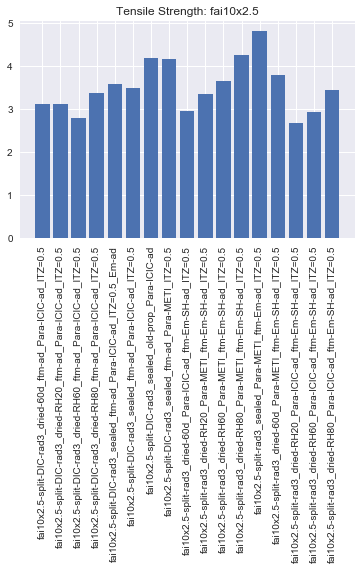

In [3]:
keys=["fai10x2.5","split","rad3","__"]
delkeys=[]
R_split=Results(keys,delkeys).Summary()

fai10x2.5-split-rad2-no5mm_sealed_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.41
fai10x2.5-split-rad2-no5mm_sealed_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.96
fai10x2.5-split-rad2_dried-60d_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=2.70
fai10x2.5-split-rad2_dried-RH20_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=2.53
fai10x2.5-split-rad2_dried-RH60_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=2.72
fai10x2.5-split-rad2_dried-RH80_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.44
fai10x2.5-split-rad2_sealed_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.42
fai10x2.5-split-rad2_sealed_Para-METI_ftm-Em-SH-ad_ITZ=0.5 : Ft=3.97
fai10x2.5-split-rad2_dried-60d_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5_step-small2 : Ft=2.70
fai10x2.5-split-rad2_dried-60d_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5_AggSH-L : Ft=2.90
fai10x2.5-split-rad2_dried-RH20_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5_AggSH-L : Ft=3.11
fai10x2.5-split-rad2_dried-RH60_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5_AggSH-L : Ft=3.11
fai10x2.5-split-rad2_dried-RH80_Para-ICIC-ad_ftm-Em-SH-ad_ITZ=0.5

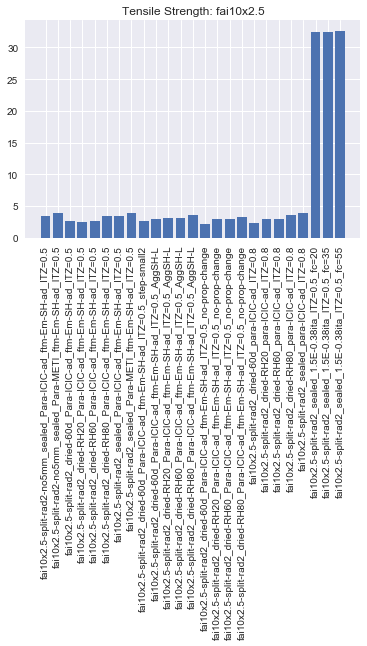

In [2]:
keys=["fai10x2.5","split","rad2","__"]
delkeys=[]
R_split=Results(keys,delkeys).Summary()

fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=20 : Ec=23.20, Fc=25.02, SH=0.00
fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=35 : Ec=26.84, Fc=40.82, SH=0.00
fai5-G3-2mm_sealed_Para-Ogawa_calib_ITZ=0.75_fc=55 : Ec=30.92, Fc=59.55, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-ICIC-ad_ITZ=0.5_fc=20 : Ec=22.44, Fc=21.77, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-ICIC-ad_ITZ=0.5_fc=35 : Ec=26.67, Fc=36.61, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-ICIC-ad_ITZ=0.5_fc=55 : Ec=31.38, Fc=53.72, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-METI_ITZ=0.5_fc=20 : Ec=22.50, Fc=23.75, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-METI_ITZ=0.5_fc=35 : Ec=26.79, Fc=39.87, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-METI_ITZ=0.5_fc=55 : Ec=31.56, Fc=58.37, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-Yama_ITZ=0.5_fc=20 : Ec=18.66, Fc=23.19, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-Yama_ITZ=0.5_fc=35 : Ec=22.36, Fc=36.93, SH=0.00
fai5-G3_sealed_calib_ftm-ad_Para-Yama_ITZ=0.5_fc=55 : Ec=26.21, Fc=51.88, SH=0.00
fai5-G3_se

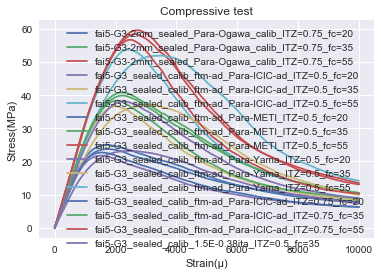

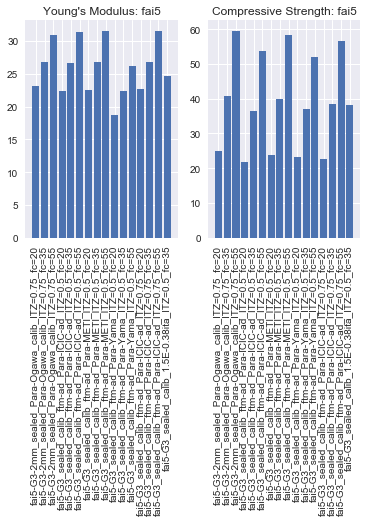

In [3]:
keys=["fai5","G3","fc=","__"]
delkeys=["split"]
R=Results(keys,delkeys).Summary()

fai10x5-split-DIC-Take_dried-60d_Para-ICIC-ad : Ft=3.25
fai10x5-split-DIC-Take_dried-RH20_Para-ICIC-ad : Ft=2.77
fai10x5-split-DIC-Take_dried-RH60_Para-ICIC-ad : Ft=3.07
fai10x5-split-DIC-Take_dried-RH80_Para-ICIC-ad : Ft=3.67
fai10x5-split-DIC-Take_31.5%_dried-60d_calib_Para-ICIC-ad : Ft=0.00
fai10x5-split-DIC-Take_31.5%_sealed_calib_Para-ICIC-ad : Ft=4.25
fai10x5-split-DIC-Take_dried-RH20_calib_Para-ICIC-ad_boun-all : Ft=3.47
fai10x5-split-DIC-Take_dried-RH60_calib_Para-ICIC-ad_boun-all : Ft=3.40
fai10x5-split-DIC-Take_dried-RH80_calib_Para-ICIC-ad_boun-all : Ft=4.02
fai10x5-split-DIC-Take_sealed_calib_Para-ICIC-ad : Ft=4.07
fai10x5-split-DIC-Take_sealed_Para-ICIC-ad : Ft=4.07
fai10x5-split-DIC_dried-60d_Para-ICIC-ad_ITZ=0.75 : Ft=3.38
fai10x5-split-DIC_sealed_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.40
fai10x5-split-DIC_sealed_ftm-Em-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.47
fai10x5-split-DIC_dried-60d_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ft=3.21
fai10x5-split-DIC_dried-RH20_ftm-ad_Para-ICIC-ad_ITZ=0.5 

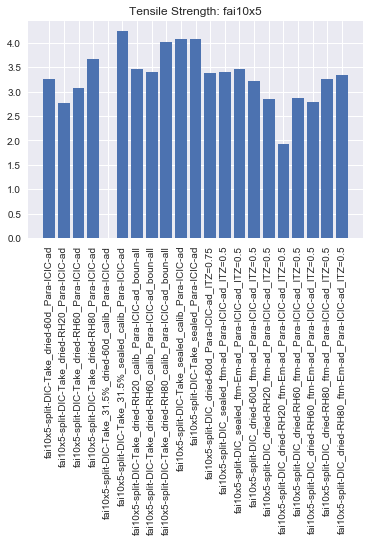

In [3]:
keys=["fai10x5","split","Para-ICIC","__"]
delkeys=["fc="]
R_split=Results(keys,delkeys).Summary()

fai4x6_NI-GA_dried-70d : Ec=21.89, Fc=65.68, SH=-906.01
fai4x6_NI-GA_sealed : Ec=32.91, Fc=70.53, SH=0.00
fai4x6-NI-GA_dried-70d_exp-1000_use-data : Ec=18.85, Fc=61.53, SH=-247.96
fai4x6-NI-GA_dried-70d_exp-12500_use-data : Ec=4.13, Fc=27.54, SH=8552.73
Is Peak value too large? peak:11566.666666666664
fai4x6-NI-GA_dried-70d_exp-20000_use-data : Ec=2.08, Fc=17.39, SH=14775.39
fai4x6-NI-GA_dried-70d_exp-5000_use-data : Ec=10.54, Fc=45.70, SH=2628.84
fai4x6-NI-GA_dried-70d_exp-12500_plateE-1TPa : Ec=4.09, Fc=26.46, SH=8550.24
fai4x6-NI-GA_dried-70d_exp-1000_Para-ICIC-ad_Mor2 : Ec=17.04, Fc=56.58, SH=-163.12
fai4x6-NI-GA_dried-70d_exp-12500_Para-ICIC-ad_Mor2 : Ec=3.44, Fc=22.59, SH=8864.38
Is Peak value too large? peak:10659.999999999998
fai4x6-NI-GA_dried-70d_exp-20000_Para-ICIC-ad_Mor2 : Ec=1.64, Fc=13.06, SH=15199.53
fai4x6-NI-GA_dried-70d_exp-5000_Para-ICIC-ad_Mor2 : Ec=8.95, Fc=40.42, SH=2804.33
fai4x6-NI-GA_dried-70d_exp-12500_Para-ICIC-ad_Mor3 : Ec=3.47, Fc=22.28, SH=8874.02
fai4x6-

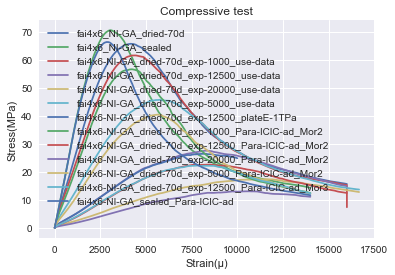

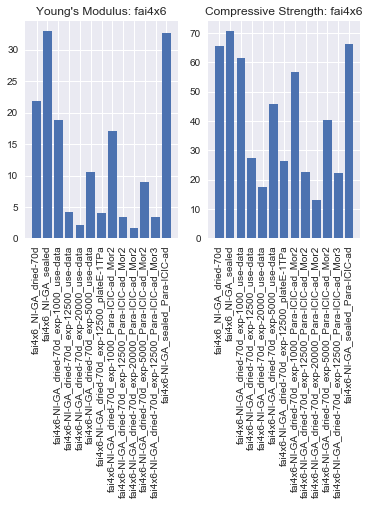

In [8]:
keys=["fai4x6","NI-GA","__"]
delkeys=["calib"]
R_split=Results(keys,delkeys).Summary()

fai5-G3-2mm_Em-ad_dried-70d_Para-ICIC-ad : Ec=18.28, Fc=43.92, SH=-721.88
fai5-G3-2mm_Em-ad_sealed_Para-ICIC-ad_40u : Ec=30.31, Fc=47.64, SH=0.00
fai5-G3-2mm_AggVol32%_dried-70d_Para-ICIC-ad : Ec=nan, Fc=0.00, SH=-847.82
fai5-G3-2mm_AggVol32%_sealed_Para-ICIC-ad : Ec=23.29, Fc=45.55, SH=0.00
fai5-G3-2mm_Em-ad_dried-RH20_Para-ICIC-ad : Ec=20.11, Fc=43.39, SH=-445.74
fai5-G3-2mm_Em-ad_dried-RH60_Para-ICIC-ad : Ec=20.96, Fc=41.34, SH=-393.27
fai5-G3-2mm_Em-ad_dried-RH80_Para-ICIC-ad : Ec=24.92, Fc=45.28, SH=-301.85
fai5-G3_sealed_Para-ICIC-ad_ftm-ad_ITZ=0.5 : Ec=24.11, Fc=44.45, SH=0.00
fai5-G3_dried-70d_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ec=16.47, Fc=41.40, SH=-776.69
fai5-G3_dried-RH20_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ec=17.90, Fc=40.94, SH=-488.62
fai5-G3_dried-RH60_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ec=18.96, Fc=39.09, SH=-421.63
fai5-G3_dried-RH80_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ec=21.91, Fc=42.69, SH=-322.09
fai5-G3_sealed_ftm-ad_Para-ICIC-ad_ITZ=0.5 : Ec=24.21, Fc=45.11, SH=0.00
fai5-G3_sealed_ft

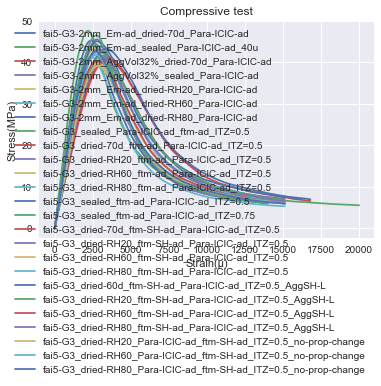

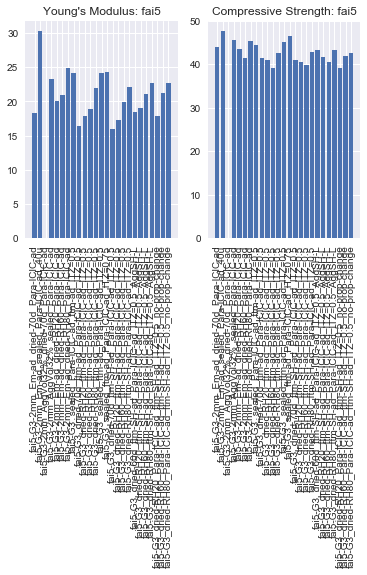

In [3]:
keys=["fai5","G3","Para","__"]
delkeys=["split","fc="]
R=Results(keys,delkeys).Summary()

fai10x5-split-DIC-Take_dried-60d_Para-ICIC-ad : Ft=3.25
fai10x5-split-DIC-Take_dried-RH20_Para-ICIC-ad : Ft=2.77
fai10x5-split-DIC-Take_dried-RH60_Para-ICIC-ad : Ft=3.07
fai10x5-split-DIC-Take_dried-RH80_Para-ICIC-ad : Ft=3.67
fai10x5-split-DIC-Take_31.5%_dried-60d_calib_Para-ICIC-ad : Ft=0.00
fai10x5-split-DIC-Take_31.5%_sealed_calib_Para-ICIC-ad : Ft=4.25
fai10x5-split-DIC-Take_dried-RH20_calib_Para-ICIC-ad_boun-all : Ft=3.47
fai10x5-split-DIC-Take_dried-RH60_calib_Para-ICIC-ad_boun-all : Ft=3.40
fai10x5-split-DIC-Take_dried-RH80_calib_Para-ICIC-ad_boun-all : Ft=4.02
fai10x5-split-DIC-Take_sealed_calib_Para-ICIC-ad : Ft=4.07


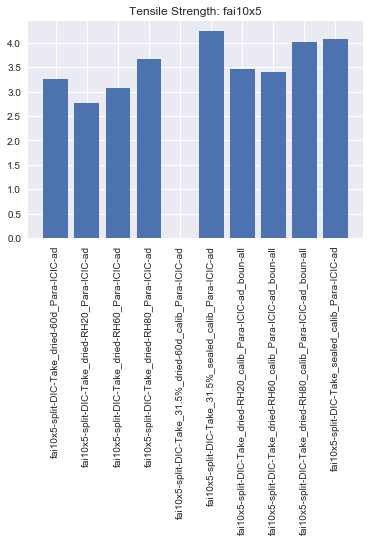

In [4]:
keys=["fai10x5","split","ICIC-ad","__"]
delkeys=["fc="]
R=Results(keys,delkeys).Summary()

fai10x5-split-DIC_uni-mat-rad2.5_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ft=1.99
fai10x5-split-DIC_uni-mat-rad2.5_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ft=3.46
fai10x5-split-DIC_uni-mat-rad2.5_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad : Ft=5.05
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ft=1.92
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ft=2.95
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad : Ft=3.88
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Ogawa : Ft=2.13
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-Yama : Ft=1.70
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Ogawa : Ft=3.26
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-Yama : Ft=2.38
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Ogawa : Ft=4.47
fai10x5-split-DIC_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-Yama : Ft=3.05
fai10x5-uni-mat-split-rad2_calib_sealed_para-ICIC

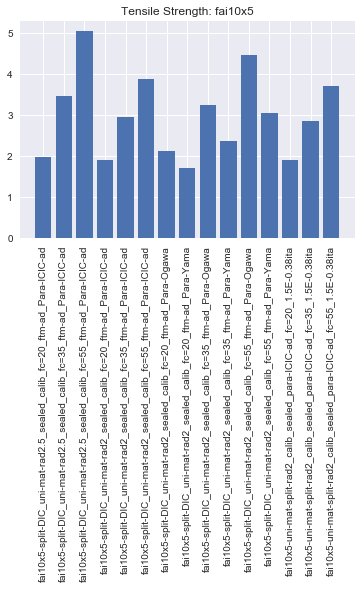

In [12]:
keys=["fai10x5","split","calib","uni-mat","__"]
delkeys=[]
R=Results(keys,delkeys).Summary()

fai4x6-v2(OldMesh)_dried-70d_exp-12500 : Ec=23.23, Fc=70.57, SH=1280.53


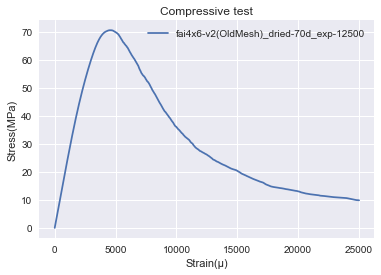

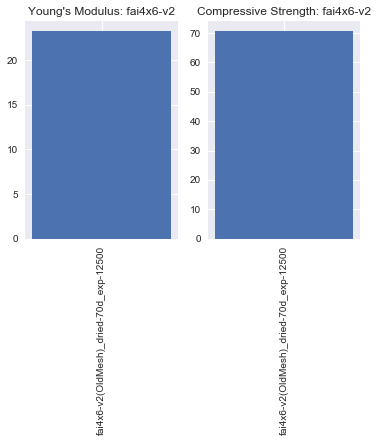

In [6]:
keys=["fai4x6-v2","__"]
delkeys=["split","calib"]
R_split=Results(keys,delkeys).Summary()

fai5_uni-mat-rad2_sealed_calib_fc=20_ftm-ad_Para-ICIC-ad : Ec=19.41, Fc=21.60, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=35_ftm-ad_Para-ICIC-ad : Ec=23.05, Fc=37.68, SH=0.00
fai5_uni-mat-rad2_sealed_calib_fc=55_ftm-ad_Para-ICIC-ad : Ec=27.90, Fc=57.23, SH=0.00


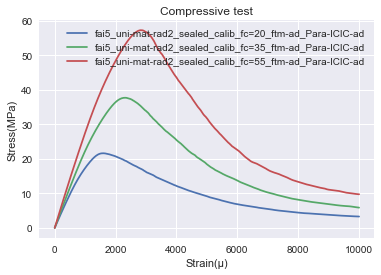

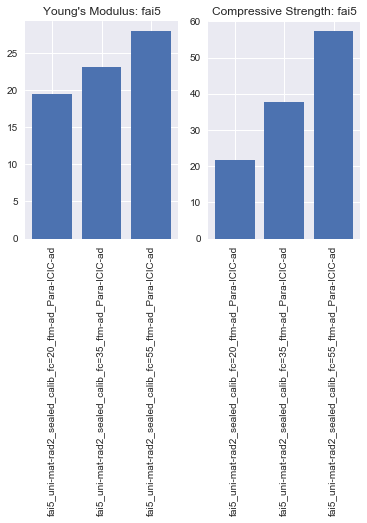

In [4]:
keys=["fai5","uni-mat","__"]
delkeys=["split"]
R_split=Results(keys,delkeys).Summary()

fai5-G3-2mm_sealed_para-ICIC_AggFc=150_Agg-Ft=7 : Ec=24.36, Fc=48.33, SH=0.00
fai5-G3-2mm_sealed_para-ICIC_ITZ=0.25 : Ec=23.52, Fc=45.71, SH=0.00
fai5-G3-2mm_sealed_para-ICIC_ITZ=0.75 : Ec=24.45, Fc=50.54, SH=0.00


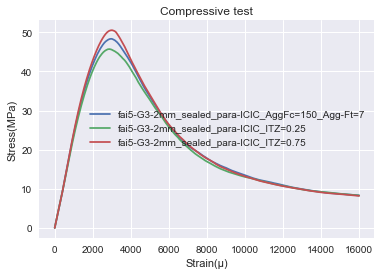

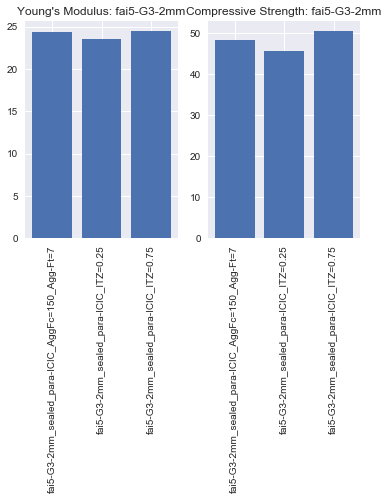

In [31]:
keys=["fai5-G3-2mm","ICIC","__"]
delkeys=["split","calib"]
R_split=Results(keys,delkeys).Summary()

In [12]:
keys=["fai10x5","split","DIC","__"]
delkeys=[]
R_split=Results(keys,delkeys).Summary()

ParserError: Error tokenizing data. C error: Expected 64 fields in line 502, saw 70


fai5-mortar_sealed_calib_para-Ogawa(fc-lim=0.55)_shear-soft=x1 : Ec=18.80, Fc=47.52, SH=0.00
fai5-mortar_sealed_calib_para-Yama : Ec=15.60, Fc=40.88, SH=0.00
fai5-mortar_sealed_calib_para-Yama_Gft=1.0_ft=1.0_Ec=1.5 : Ec=16.66, Fc=45.12, SH=0.00
fai5-uni-mat-mortar_sealed_calib_ita=0.375_lim-fc=0.55 : Ec=16.99, Fc=47.56, SH=0.00
fai5-uni-mat-mortar_sealed_calib_lim-fc=0.55_ft=1.0_ita=0.394 : Ec=15.60, Fc=40.88, SH=0.00
fai5-uni-mat-mortar_calib_sealed_Para-Ogawa : Ec=18.73, Fc=51.43, SH=0.00


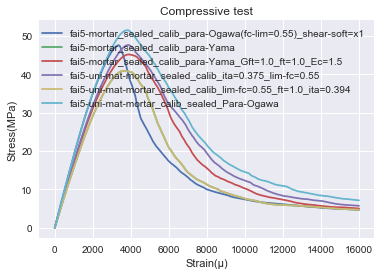

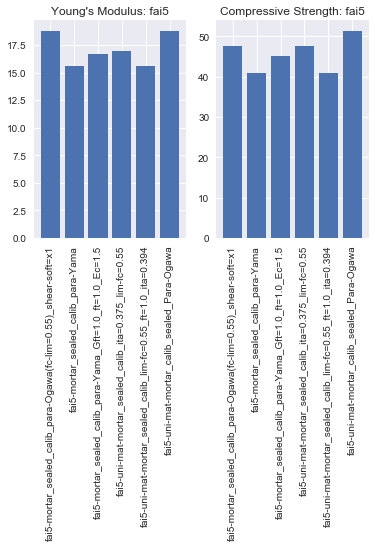

In [29]:
keys=["fai5","sealed","mortar","calib","__"] #Target Fcm=46.6, Ecm=16.9
delkeys=["split"]
R_split=Results(keys,delkeys).Summary()

fai10x5-split_uni-mat-mortar_sealed_calib_para-Yama_Gft=1.0 : Ft=3.89
fai10x5-split-uni-mat_sealed_calib_Mortar Para-Yama_ft=0.9_Ec=1.5 : Ft=4.12
fai10x5-split-uni-mat_sealed_calib_Mortar Para-Yama_ft=1.0_Ec=1.5 : Ft=4.01
fai10x5-split-uni-mat_sealed_Mortar_calib_lim-fc=0.55_ft=1.0_ita=0.375 : Ft=4.32
fai10x5-split-uni-mat_sealed_calib_ita=0.394 : Ft=4.37


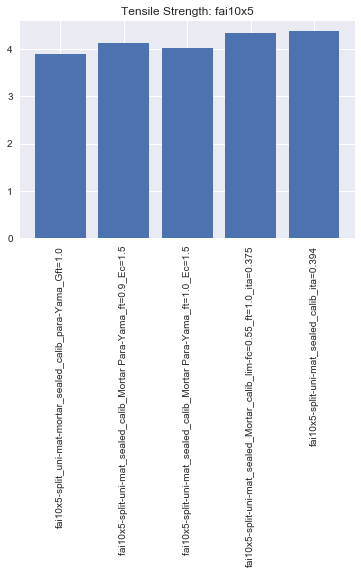

In [25]:
keys=["fai10x5","split","uni-mat","__"] #Target: Ftm=3.76
delkeys=[]
R_split=Results(keys,delkeys).Summary()

sealed : Ft=4.62
dried-60d : Ft=3.33
dried-60d_agg-sh-L : Ft=3.51
dried-RH20_1.75lim_agg-sh-L : Ft=3.71
dried-RH20_1.75lim : Ft=3.71
dried-RH60_1.75lim_agg-sh-L : Ft=4.45
dried-RH60_1.75lim : Ft=4.28
dried-RH80_1.75lim_agg-sh-L : Ft=5.11
dried-RH80_1.75Lim : Ft=4.99
mortar_dried-60d : Ft=5.31
mortar_dried-RH80 : Ft=5.24
mortar_sealed : Ft=5.10


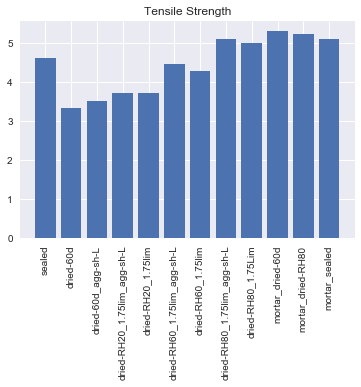

In [86]:
keys=["__","split"]
R=Results(keys).Summary()

fai4_sealed_Ea80_Em27_fc65_ft4.15 : Ec=33.57, Fc=73.76, SH=0.00
fai5x10-v2_sealed : Ec=33.92, Fc=67.67, SH=0.00
fai10x20_sealed : Ec=23.12, Fc=50.96, SH=-531.26
fai4-v2_sealed : Ec=33.32, Fc=74.10, SH=0.00
fai5x10-coarse_sealed : Ec=31.80, Fc=60.09, SH=0.00


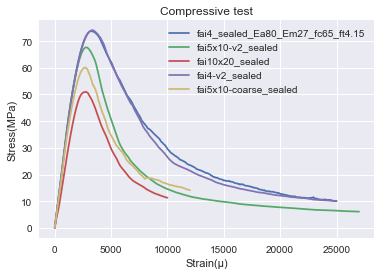

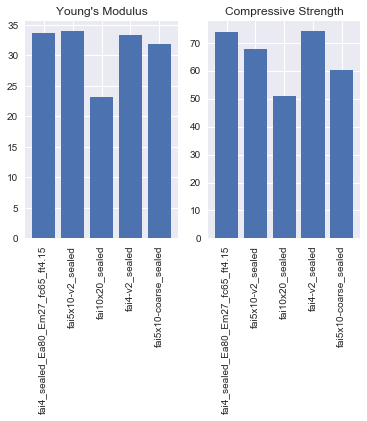

In [43]:
keys=["__","sealed"]
delkeys=["split","mortar","Ogawa"]
R=Results(keys,delkeys).Summary()

In [35]:
name="fai10x5-coarse_exp"
re.sub("fai.*?(_|-)","",name)

'coarse_exp'

In [40]:
def rm_shape(label,shape=[]):
    if not shape: 
        pass #return #label #shape指定がない場合触らない passでもOK?
    else:
        return [re.sub("fai.*?(_|-)","",name,1) for name in label]
        
name="fai10x5-coarse_exp"

rm_shape(name)

fai4-v2_dried-60d_exp-1000 : Ec=21.79, Fc=76.09, SH=-187.48
fai4-v2_dried-60d_exp-12500 : Ec=4.50, Fc=42.18, SH=8905.92
fai4-v2_dried-60d_exp-5000 : Ec=11.77, Fc=62.55, SH=2754.18
Is Peak value too large? peak:11400.000000000002
fai4_dried-60d_exp-12500_only-agg : Ec=3.23, Fc=33.27, SH=8539.44


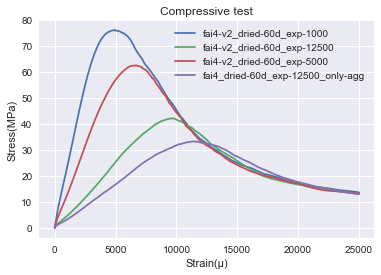

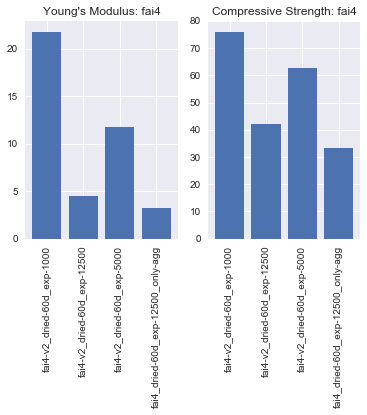

In [24]:
keys=["__","fai4","181027"]
delkeys=["fai5x10","ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()

fai10x5-split-v2_sealed : Ft=4.45
fai10x5-split_dried-60d_exp-1000 : Ft=5.47
fai10x5-split_dried-60d_exp-12500 : Ft=2.16


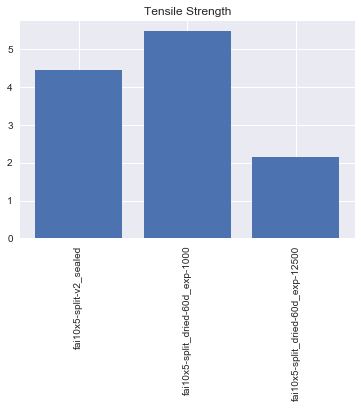

In [25]:
keys=["__","split","181027"]
delkeys=["fai5x10","ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()

fai5x10-coarse_dried-60d_exp-12500 : Ec=3.73, Fc=23.02, SH=8050.90
fai5x10-coarse_sealed : Ec=31.80, Fc=60.09, SH=0.00
fai5x10-coarse_dried-60d_exp-1000 : Ec=18.62, Fc=59.12, SH=-314.84
fai5x10-coarse_dried-60d_exp-12500 : Ec=3.79, Fc=26.47, SH=7890.95
fai5x10-coarse_dried-60d_exp-5000 : Ec=9.25, Fc=44.21, SH=2403.96


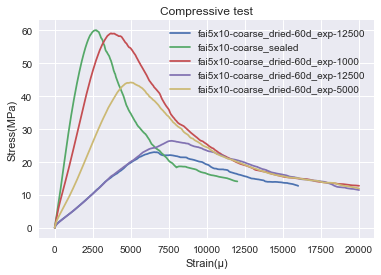

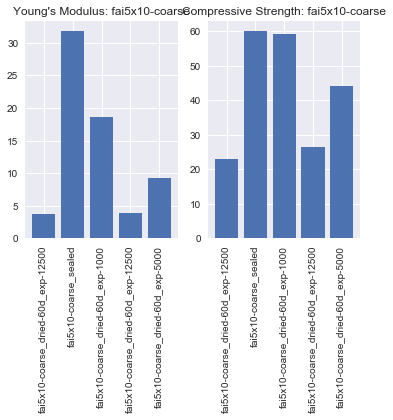

In [33]:
keys=["__","fai5x10-coarse"]
delkeys=["ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()

fai10x20_sealed : Ec=32.64, Fc=59.88, SH=0.00
fai10x20_dried-60d_exp-1000 : Ec=19.49, Fc=60.42, SH=-344.97
fai10x20_dried-60d_exp-12500 : Ec=4.43, Fc=25.96, SH=7443.86
fai10x20_dried-60d_exp-5000 : Ec=10.42, Fc=45.65, SH=2235.05


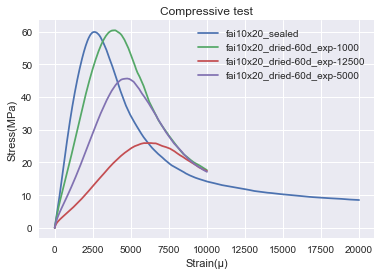

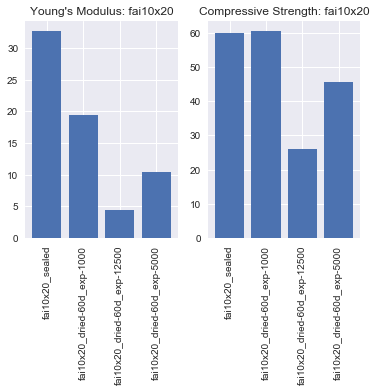

In [2]:
keys=["__","fai10x20"]
delkeys=["ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()

fai5x10-v2_dried-60d_exp-1000 : Ec=25.01, Fc=69.88, SH=55.67
fai5x10-v2_dried-60d_exp-12500 : Ec=4.27, Fc=26.30, SH=8790.68
fai5x10-v2_dried-60d_exp-5000 : Ec=13.99, Fc=50.44, SH=2766.77
fai5x10-v2_sealed : Ec=33.92, Fc=67.67, SH=0.00
fai5x10_dried-60d_prop-Take_agg-sh-L : Ec=23.32, Fc=49.49, SH=-708.27
fai5x10-coarse_dried-60d_exp-12500 : Ec=3.73, Fc=23.02, SH=8050.90
fai5x10-coarse_sealed : Ec=31.80, Fc=60.09, SH=0.00
fai5x10-coarse_dried-60d_exp-1000 : Ec=18.62, Fc=59.12, SH=-314.84
fai5x10-coarse_dried-60d_exp-12500 : Ec=3.79, Fc=26.47, SH=7890.95
fai5x10-coarse_dried-60d_exp-5000 : Ec=9.25, Fc=44.21, SH=2403.96
fai5x10_dried-60d_exp-1000 : Ec=22.25, Fc=69.09, SH=-212.82
fai5x10_dried-60d_exp-12500 : Ec=4.08, Fc=27.34, SH=8698.06
fai5x10_dried-60d_exp-5000 : Ec=12.04, Fc=50.72, SH=2646.99


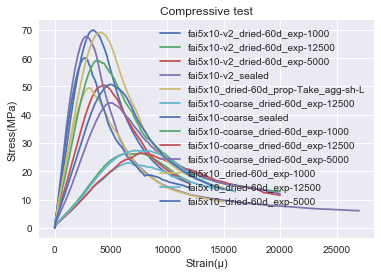

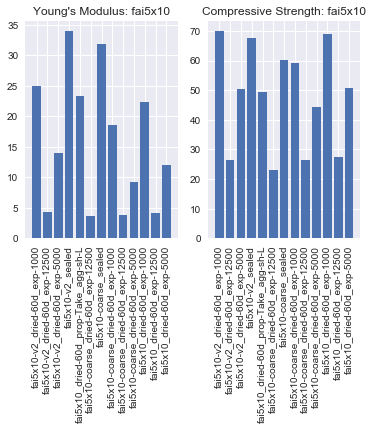

In [7]:
keys=["__","fai5x10"]
delkeys=["fai5x10-coarse","ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()

fai4-v2_sealed : Ec=33.32, Fc=74.10, SH=0.00
fai4-v2_sealed-exp-1000 : Ec=28.51, Fc=71.18, SH=406.17
fai4-v2_sealed-exp-12500 : Ec=3.36, Fc=26.77, SH=8666.63
fai4-v2_sealed-exp-5000 : Ec=10.71, Fc=51.59, SH=2964.17


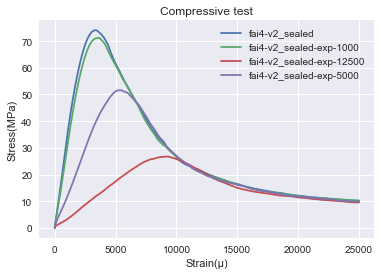

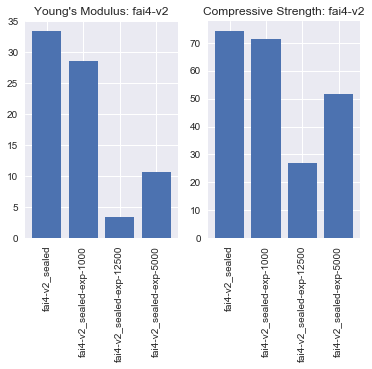

In [2]:
keys=["__","fai4-v2","sealed"]
delkeys=["fai5x10-coarse","ITZ","itz","Take","gft"]
R=Results(keys,[]).Summary()